In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

In [12]:
BOX_PTS = 9
TEST_FILES = '/home/dataset/team2/validation/validation*/*_smooth_{}.csv'.format(BOX_PTS)

test_csvs = glob.glob(TEST_FILES)
test_num = len(test_csvs)
# print(test_csvs)
print('test csv num:', len(test_csvs))

test csv num: 150


In [13]:
max_frame = 200
dim_input = 12

output_dim = max_frame * 3

test_data = []
for file in test_csvs:
    raw = pd.read_csv(file).values
    length = raw.shape[0]
    padding = np.zeros((max_frame, dim_input + 3))
    padding[:length, :] = raw
    test_data.append(padding)

test_data = np.array(test_data)
test_X = test_data[:, :, :-3]
test_y = test_data[:, :, -3:]
test_y = test_y.reshape(-1, output_dim)

print("test X: ", test_X.shape)
print("test y: ", test_y.shape)

test X:  (150, 200, 12)
test y:  (150, 600)


In [14]:
from tensorflow.keras.models import load_model

model_name = 'triple_lstm_epoch_300_hidden_256_car_following'
model_path = '/home/zg2309/model/{}.h5'.format(model_name)
print(model_path)
# load model
model = load_model(model_path)
# summarize model.
model.summary()

/home/zg2309/model/triple_lstm_epoch_300_hidden_256_car_following.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 256)          275456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 600)               154200    
Total params: 1,480,280
Trainable params: 1,480,280
Non-trainable params: 0
_________________________________________________________________


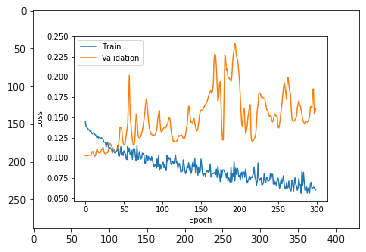

In [15]:
import matplotlib.image as mpimg
img = mpimg.imread('/home/zg2309/history/{}.png'.format(model_name))
plt.imshow(img)
plt.show()

In [16]:
score = model.evaluate(test_X, test_y, verbose=1)
print("%s: %f" % (model.metrics_names[0], score))

150/150 [==============================] - 2s 15ms/sample - loss: 0.3463
loss: 0.346278


In [17]:
# self define loss
prediction = model.predict(test_X, verbose=1)
print(prediction.shape)

150/150 [==============================] - 2s 14ms/sample
(150, 600)


In [18]:
# abandon z
predict = prediction.reshape((-1,200,3))
label = test_y.reshape((-1,200,3))


def MAE(predict, label):
    result = np.abs(predict - label)
    result = result.reshape((-1,3))
    return np.mean(result, axis=0)
    
def MSE(predict, label):
    result = (predict - label)**2
    result = result.reshape((-1, 3))
    return np.mean(result, axis=0)
    
mae_x, mae_y, mae_z = MAE(predict, label)
mse_x, mse_y, mse_z = MSE(predict, label)

print('MAE X: {}, Y: {}, Z: {}'.format(mae_x,mae_y,mae_z))
print('MSE X: {}, Y: {}, Z: {}'.format(mse_x,mse_y,mse_z))

MAE X: 0.464636881976862, Y: 0.49681088797325945, Z: 0.07106175936739093
MSE X: 0.4998758890208751, Y: 0.5278137129776962, Z: 0.011143130867517339


In [19]:
print(np.mean(abs(label.reshape(-1,3)), axis=0))

[0.34746601 0.32439568 0.04723805]


In [10]:
# test_csvs = glob.glob('/home/zg2309/result/validation*/*/data_smooth.csv')
# test_num = len(test_csvs)
# # print(test_csvs)
# print('test csv num:', len(test_csvs))
# count = 0
# for file in test_csvs:
#     raw = pd.read_csv(file).values
#     length = raw.shape[0]
#     padding = np.zeros((max_frame, dim_input + 3))
#     padding[:length, :] = raw
#     padding = padding[:, :-3]
    
#     test_X = np.array([padding])
#     prediction = model.predict(test_X)
#     prediction = prediction.reshape(-1, 200, 3)
#     prediction = prediction[:, :length, :].squeeze()
#     prediction_csv = '/'.join(file.split('/')[:-1]) + '/' + model_name + '_prediction.csv'
#     np.savetxt(prediction_csv, prediction, delimiter=",")
#     count += 1
#     if count % 50 == 0:
#         print('predicting: {}/{}'.format(count, test_num))